In [188]:
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

from scipy.ndimage.morphology import binary_opening as bo
from scipy.ndimage.morphology import binary_erosion as be
from scipy.ndimage.morphology import binary_closing as bc
from scipy.ndimage.morphology import binary_fill_holes as bfh

from ipywidgets import interact, fixed
from IPython.display import display
import skimage

import os
os.chdir('/Volumes/FAIR/DC-Image-Analysis/DC-project-master/cleancode/NewMidplane')
import Functions
from scipy.ndimage.interpolation import rotate


def saveImage(array,img):
    array = np.swapaxes(array,0,2)
    mask = sitk.GetImageFromArray(array)
    mask.CopyInformation(img)
    sitk.WriteImage(mask, os.path.split(path)[0] + '/ROI.nii.gz')


%matplotlib inline
os.chdir('/Volumes/FAIR/DC-Image-Analysis/python tutorials')
# Calculate parameters low and high from window and level
import image_viewer
from image_viewer import BiggestRegion,display_image
    
axis_pair8,axis_pair6,axis_pair4,axis_pair0 = [],[],[],[]
area8,area6,area4,area0 =  [],[],[],[]
maxMPS_list, centroidMPS_list,centroid_Brain = [], [],[]
vec1_list, vec2_list = [], []
volume = []
ID_list = []
Lesion_centroids = []
reference_x_list = []
volume = []

In [190]:
paths = ['/Volumes/FAIR/Registered_MPS3/SDH4/CT.nii.gz',
         '/Volumes/FAIR/Registered_MPS3/SDH7/CT.nii.gz',
         '/Volumes/FAIR/Registered_MPS3/SDH8/CT.nii.gz',
         '/Volumes/FAIR/Registered_MPS3/SDH11/CT.nii.gz',
         '/Volumes/FAIR/Registered_MPS3/SDH12/CT.nii.gz',
         '/Volumes/FAIR/Registered_MPS3/SDH14/CT.nii.gz',
         '/Volumes/FAIR/Registered_MPS3/SDH16-2/CT.nii.gz',
         '/Volumes/FAIR/Registered_MPS3/SDH24/CT.nii.gz',
         '/Volumes/FAIR/Registered_MPS3/CONT5/CT.nii.gz',
         '/Volumes/FAIR/Registered_MPS3/CONT7/CT.nii.gz',
         '/Volumes/FAIR/Registered_MPS3/EDH7/CT.nii.gz',
         '/Volumes/FAIR/Registered_MPS3/tutorial3/CT.nii.gz',
        ]
# paths = ['/Volumes/FAIR/Registered_MPS3/MPS1',
#          '/Volumes/FAIR/Registered_MPS3/MPS2',
#          '/Volumes/FAIR/Registered_MPS3/MPS3',
#          '/Volumes/FAIR/Registered_MPS3/MPS4',
#          '/Volumes/FAIR/Registered_MPS3/MPS5',
#          '/Volumes/FAIR/Registered_MPS3/MPS6',
#          '/Volumes/FAIR/Registered_MPS3/MPS7',
#          '/Volumes/FAIR/Registered_MPS3/MPS8',
#          '/Volumes/FAIR/Registered_MPS3/MPS9',
#          '/Volumes/FAIR/Registered_MPS3/MPS10',
#          '/Volumes/FAIR/Registered_MPS3/MPS11',
#          '/Volumes/FAIR/Registered_MPS3/MPS12',
#          '/Volumes/FAIR/Registered_MPS3/MPS13',
#          '/Volumes/FAIR/Registered_MPS3/MPS14',
#          '/Volumes/FAIR/Registered_MPS3/SDH4',
#          '/Volumes/FAIR/Registered_MPS3/SDH7',
#          '/Volumes/FAIR/Registered_MPS3/SDH8',
#          '/Volumes/FAIR/Registered_MPS3/SDH11',
#          '/Volumes/FAIR/Registered_MPS3/SDH12',
#          '/Volumes/FAIR/Registered_MPS3/SDH14',
#          '/Volumes/FAIR/Registered_MPS3/SDH16-2',
#          '/Volumes/FAIR/Registered_MPS3/SDH24',
#          '/Volumes/FAIR/Registered_MPS3/CONT5',
#          '/Volumes/FAIR/Registered_MPS3/CONT7',
#          '/Volumes/FAIR/Registered_MPS3/EDH7',
#          '/Volumes/FAIR/Registered_MPS3/Sample3_Pre',
#          '/Volumes/FAIR/Registered_MPS3/Sample3_Post',
#          '/Volumes/FAIR/Registered_MPS3/Sample4_Pre',
#          '/Volumes/FAIR/Registered_MPS3/tutorial3',
#          '/Volumes/FAIR/Registered_MPS3/ScanD',
#          '/Volumes/FAIR/Registered_MPS3/ScanE',
#          '/Volumes/FAIR/Registered_MPS3/ScanF',
#          '/Volumes/FAIR/Registered_MPS3/ScanH',
#         ]

for m in range(len(paths)):
# for m in range(30,31):
    path = paths[m]
    print( "Reading directory:", path)
#     mask = sitk.ReadImage(path + '/lesion.nii.gz')
    mask = sitk.ReadImage(path + '/manu_Lesion.nii.gz')
    Mask_array = sitk.GetArrayFromImage(mask)
    Mask_array = np.swapaxes(Mask_array,0,2)
    ConstPixelSpacing = mask.GetSpacing()
    ID = os.path.split(path)[1]
    
    def reshape(array, ConstPixelSpacing):
        """ Reshape array to have cubic voxels of size 1mm^3 """
        '''mind the a, b, c value is adjusted to make each '''

        width = array.shape[0]
        height = array.shape[1]
        depth = array.shape[2]
        a = int((width)*ConstPixelSpacing[0])
        b = int((height)*ConstPixelSpacing[1])
        c = int((depth)*ConstPixelSpacing[2])
        reshapedArray1 = np.zeros((a,height,depth))
        xp = np.linspace(0, (width-1)*ConstPixelSpacing[0], width) #adjust xp as [0,1ConstPixelSpacing,2CPS..
        x  = np.linspace(0, a-1, a)

        for j in range(height):
            for k in range(depth):
                reshapedArray1[:,j,k] = np.interp(x, xp, array[:,j,k])
        reshapedArray2 = np.zeros((a,b,depth))
        yp = np.linspace(0,(height-1)*ConstPixelSpacing[1],height)
        y = np.linspace(0,b-1,b)
        for j in range(a):
            for k in range(depth):
                reshapedArray2[j,:,k] = np.interp(y, yp, reshapedArray1[j,:,k])
        reshapedArray3 = np.zeros((a,b,c))
        zp = np.linspace(0,(depth-1)*ConstPixelSpacing[2],depth)
        z = np.linspace(0,c-1,c)
        for j in range(a):
            for k in range(b):
                reshapedArray3[j,k,:] = np.interp(z, zp, reshapedArray2[j,k,:])
        return reshapedArray3

#     Read lesion array
    Lesion_array = np.zeros(Mask_array.shape)
    # Lesion_array[Mask_array==19] = 1
    Lesion_array[Mask_array==1] = 1
    Mask_array = Lesion_array
    np.nonzero(Mask_array)
    
    mp = sitk.ReadImage(path + '/MPS.nii.gz')
    mp_array = sitk.GetArrayFromImage(mp)
    mp_array = np.swapaxes(mp_array,0,2)
    ConstPixelSpacing = mp.GetSpacing()

    ml = sitk.ReadImage(path + '/Midplane_Q.nii.gz')
    ml_array = sitk.GetArrayFromImage(ml)
    ml_array = np.swapaxes(ml_array,0,2)

    sku = sitk.ReadImage(path + '/Skull_contour.nii.gz')
    sku_array = sitk.GetArrayFromImage(sku)
    sku_array = np.swapaxes(sku_array,0,2)

    if ConstPixelSpacing != (1,1,1):
        Reshaped_mp = reshape(mp_array,ConstPixelSpacing)
        Reshaped_ml = reshape(ml_array,ConstPixelSpacing)
        Reshaped_sku = reshape(sku_array,ConstPixelSpacing)
        Reshaped_lesion = reshape(Lesion_array,ConstPixelSpacing)


    else:
        Reshaped_mp = mp_array
        Reshaped_ml = ml_array
        Reshaped_sku = sku_array
        Reshaped_lesion = Lesion_array

    #Import ideal midplane parameters
    paras = np.load("/Volumes/FAIR/Registered_MPS3/MPS_para2.npy",encoding= 'bytes')


    # img_gauss = sitk.DiscreteGaussian(img, variance=1)
    # display_image(img_gauss,window=120, level=40)

    # paras = np.load('/Volumes/FAIR/DC-Image-Analysis/DC-project-master/cleancode/NewMidplane/Final_preop.npy')
    file, a, b, c, d = paras[m]
    a, b, c, d = a.astype(float),b.astype(float),c.astype(float),d.astype(float)
    v = np.array((a,b,c))
    v = v.astype(float)
    print(file, a, b, c, d, path)

    # midplane normal vector regulate the direction
    if a<0:
        a,b,c,d = a*-1,b*-1,c*-1,d*-1
    n = np.array((a,b,c))

    #define rotation axis in plane, in z direction correlates to skew angle
    from sympy import *
    import sympy
    x = sympy.symbols('x')
    x1 = solve(a*x + b*100 + c*0 - d, x)
    x2 = solve(a*x + b*100 + c*100 - d, x)
    k = np.array((x1[0]-x2[0],0,-100)).astype(float)
    # k = k/np.sqrt((k[0]**2 + k[1]**2 + k[2]**2))
    vk_unit = Functions.unit_vector(k)
    vk_unit

    ## Define rotation axis in y direction, correlating to the orientation angle
    x = sympy.symbols('x')
    x3 = solve(a*x + b*0.0 + c*100.0- d, x)
    x4 = solve(a*x + b*100.0 + c*100.0 - d, x)

    k2 = np.array((x3[0]-x4[0],-100.0,0.0)).astype(float)
    vk2_unit = Functions.unit_vector(k2)
    # the new_vk corresponds to the reshaped version of array, as displayed in ITK
    # new_vk = Functions.unit_vector(vk_unit*ConstPixelSpacing)
    vk2_unit

    #the orientation angle
    yaxis = np.array((0,1,0))
    angle_ori = Functions.ang(vk2_unit,yaxis)
    zaxis = np.array((0,0,1))
    # angle_skew = Functions.ang(new_vk,zaxis)
    angle_skew = Functions.ang(vk_unit,zaxis)

    # Convert to degrees
    # The skew angle 
    A_S = 180.0 - angle_skew/np.pi*180.0
    # The orientation angle
    A_O = 180.0 - angle_ori/np.pi*180.0

    if vk2_unit[0]*vk2_unit[1] < 0.0:
        A_O = -1*A_O

    if vk_unit[0]*vk_unit[2] < 0.0:
        A_S = -1*A_S

    # Calculate the x-coordinate of the miplane, should be a uniform value

    # Constant mode rotation, points outside the boundaries of the input 
    # are filled with constant 0.0. If points

    # ML_array = array
    # ideal midplane
    Ideal_ML = np.multiply(Reshaped_ml >0.2, Reshaped_ml)
    # mask = active_mask

    from scipy.ndimage.interpolation import rotate
    r_ml = rotate(Ideal_ML,A_O,mode='constant',axes=(0,1))
    r2_ml = rotate(r_ml,A_S,mode='constant',axes=(0,2))

    r_mp = rotate(Reshaped_mp,A_O,mode='constant',axes=(0,1))
    r2_mp = rotate(r_mp,A_S,mode='constant',axes=(0,2))

    binary_mp = np.multiply(r2_mp,r2_mp > 0.1)

    r_sku = rotate(Reshaped_sku,A_O,mode='constant',axes=(0,1))
    r2_sku = rotate(r_sku,A_S,mode='constant',axes=(0,2))

    r_lesion = rotate(Reshaped_lesion,A_O,mode='constant',axes=(0,1))
    r2_lesion = rotate(r_lesion,A_S,mode='constant',axes=(0,2))
    
#     i1 = 30
#     i2 = int((float(i1)/sku_array.shape[2])*r2_sku.shape[2])

#     plt.figure(figsize=(16,5))
#     plt.subplot(141)
#     plt.imshow(Reshaped_mp[:,:,i1])

#     plt.subplot(142)
#     plt.imshow(Reshaped_lesion[:,:,i2])

#     plt.subplot(143)
#     plt.imshow(r2_lesion[:,:,i2])
#     plt.show()
    
    Binary_Mask = np.zeros(r2_mp.shape)
    Binary_Mask[np.abs(r2_lesion)>0.2]=1

    Binary_sku  = np.zeros(r2_sku.shape)
    Binary_sku[np.abs(r2_sku)>0.1] = -1

    # Check the spread range of x1 value should be very small
    # Calculate the reference_x coordinates
    Binary_mp = np.zeros(r2_ml.shape)
    Binary_mp[np.abs(r2_ml)>0.4]=1
    r2_IMLq = Binary_mp
    xr = np.nonzero(r2_IMLq)[0]
    counts = np.bincount(xr)
    reference_x = np.argmax(counts)

    Skull_Contour = Binary_sku[reference_x,:,:]

    midplane_split = np.zeros(r2_mp.shape)
    for i in range(reference_x-1,r2_mp.shape[0]):
        midplane_split[i,:,:] = 1

    Left_mask = np.multiply(Binary_Mask,midplane_split==0)
    Right_mask = np.multiply(Binary_Mask,midplane_split==1)

    Left_sum = np.sum(Left_mask,0)
    Right_sum = np.sum(Right_mask,0)
    H_diff = Left_sum-Right_sum

    y,z = np.nonzero(H_diff)
    lesion_contour = Skull_Contour.copy()
    pure_lesion = np.ones(Skull_Contour.shape) * 1000

    for i in range(len(z)):
    #     Skull_Contour[z[i]-1,y[i]-1]= H_diff[z[i]-1,y[i]-1]
        lesion_contour[y[i]-1,z[i]-1]= H_diff[y[i]-1,z[i]-1]
        pure_lesion[y[i]-1,z[i]-1]= H_diff[y[i]-1,z[i]-1]

    pure_lesion[pure_lesion==1000]=np.nan
    L_coor = np.where(Binary_Mask>0)
    L_centroid = np.mean(L_coor

SyntaxError: unexpected EOF while parsing (<ipython-input-190-3e1f8a856c50>, line 262)

Reading directory: /Volumes/FAIR/Registered_MPS3/tutorial3
b'ScanD' -0.999797690093 -0.0198089433532 -0.00349065141522 -118.684126162 /Volumes/FAIR/Registered_MPS3/tutorial3


/anaconda/envs/mic3/lib/python3.6/site-packages/ipykernel_launcher.py:268: RuntimeWarning: invalid value encountered in less


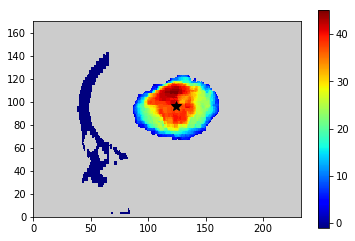

In [194]:
paths = ['/Volumes/FAIR/Registered_MPS3/SDH4',
         '/Volumes/FAIR/Registered_MPS3/SDH7',
         '/Volumes/FAIR/Registered_MPS3/SDH8',
         '/Volumes/FAIR/Registered_MPS3/SDH11',
         '/Volumes/FAIR/Registered_MPS3/SDH12',
         '/Volumes/FAIR/Registered_MPS3/SDH14',
         '/Volumes/FAIR/Registered_MPS3/SDH16-2',
         '/Volumes/FAIR/Registered_MPS3/SDH24',
         '/Volumes/FAIR/Registered_MPS3/CONT5',
         '/Volumes/FAIR/Registered_MPS3/CONT7',
         '/Volumes/FAIR/Registered_MPS3/EDH7',
         '/Volumes/FAIR/Registered_MPS3/tutorial3',
        ]
# paths = ['/Volumes/FAIR/Registered_MPS3/MPS1',
#          '/Volumes/FAIR/Registered_MPS3/MPS2',
#          '/Volumes/FAIR/Registered_MPS3/MPS3',
#          '/Volumes/FAIR/Registered_MPS3/MPS4',
#          '/Volumes/FAIR/Registered_MPS3/MPS5',
#          '/Volumes/FAIR/Registered_MPS3/MPS6',
#          '/Volumes/FAIR/Registered_MPS3/MPS7',
#          '/Volumes/FAIR/Registered_MPS3/MPS8',
#          '/Volumes/FAIR/Registered_MPS3/MPS9',
#          '/Volumes/FAIR/Registered_MPS3/MPS10',
#          '/Volumes/FAIR/Registered_MPS3/MPS11',
#          '/Volumes/FAIR/Registered_MPS3/MPS12',
#          '/Volumes/FAIR/Registered_MPS3/MPS13',
#          '/Volumes/FAIR/Registered_MPS3/MPS14',
#          '/Volumes/FAIR/Registered_MPS3/SDH4',
#          '/Volumes/FAIR/Registered_MPS3/SDH7',
#          '/Volumes/FAIR/Registered_MPS3/SDH8',
#          '/Volumes/FAIR/Registered_MPS3/SDH11',
#          '/Volumes/FAIR/Registered_MPS3/SDH12',
#          '/Volumes/FAIR/Registered_MPS3/SDH14',
#          '/Volumes/FAIR/Registered_MPS3/SDH16-2',
#          '/Volumes/FAIR/Registered_MPS3/SDH24',
#          '/Volumes/FAIR/Registered_MPS3/CONT5',
#          '/Volumes/FAIR/Registered_MPS3/CONT7',
#          '/Volumes/FAIR/Registered_MPS3/EDH7',
#          '/Volumes/FAIR/Registered_MPS3/Sample3_Pre',
#          '/Volumes/FAIR/Registered_MPS3/Sample3_Post',
#          '/Volumes/FAIR/Registered_MPS3/Sample4_Pre',
#          '/Volumes/FAIR/Registered_MPS3/tutorial3',
#          '/Volumes/FAIR/Registered_MPS3/ScanD',
#          '/Volumes/FAIR/Registered_MPS3/ScanE',
#          '/Volumes/FAIR/Registered_MPS3/ScanF',
#          '/Volumes/FAIR/Registered_MPS3/ScanH',
#         ]

for m in range(len(paths)-1,len(paths)):
# for m in range(30,31):
    path = paths[m]
    print( "Reading directory:", path)
    mask = sitk.ReadImage(path + '/manu_Lesion.nii.gz')
    Mask_array = sitk.GetArrayFromImage(mask)
    Mask_array = np.swapaxes(Mask_array,0,2)
    ConstPixelSpacing = mask.GetSpacing()
    ID = os.path.split(path)[1]
    
    def reshape(array, ConstPixelSpacing):
        """ Reshape array to have cubic voxels of size 1mm^3 """
        '''mind the a, b, c value is adjusted to make each '''

        width = array.shape[0]
        height = array.shape[1]
        depth = array.shape[2]
        a = int((width)*ConstPixelSpacing[0])
        b = int((height)*ConstPixelSpacing[1])
        c = int((depth)*ConstPixelSpacing[2])
        reshapedArray1 = np.zeros((a,height,depth))
        xp = np.linspace(0, (width-1)*ConstPixelSpacing[0], width) #adjust xp as [0,1ConstPixelSpacing,2CPS..
        x  = np.linspace(0, a-1, a)

        for j in range(height):
            for k in range(depth):
                reshapedArray1[:,j,k] = np.interp(x, xp, array[:,j,k])
        reshapedArray2 = np.zeros((a,b,depth))
        yp = np.linspace(0,(height-1)*ConstPixelSpacing[1],height)
        y = np.linspace(0,b-1,b)
        for j in range(a):
            for k in range(depth):
                reshapedArray2[j,:,k] = np.interp(y, yp, reshapedArray1[j,:,k])
        reshapedArray3 = np.zeros((a,b,c))
        zp = np.linspace(0,(depth-1)*ConstPixelSpacing[2],depth)
        z = np.linspace(0,c-1,c)
        for j in range(a):
            for k in range(b):
                reshapedArray3[j,k,:] = np.interp(z, zp, reshapedArray2[j,k,:])
        return reshapedArray3

#     Read lesion array
    Lesion_array = np.zeros(Mask_array.shape)
    # Lesion_array[Mask_array==19] = 1
    Lesion_array[Mask_array==1] = 1
    Mask_array = Lesion_array
    np.nonzero(Mask_array)
    
    mp = sitk.ReadImage(path + '/MPS.nii.gz')
    mp_array = sitk.GetArrayFromImage(mp)
    mp_array = np.swapaxes(mp_array,0,2)
    ConstPixelSpacing = mp.GetSpacing()

    ml = sitk.ReadImage(path + '/Midplane_Q.nii.gz')
    ml_array = sitk.GetArrayFromImage(ml)
    ml_array = np.swapaxes(ml_array,0,2)

    sku = sitk.ReadImage(path + '/Skull_contour.nii.gz')
    sku_array = sitk.GetArrayFromImage(sku)
    sku_array = np.swapaxes(sku_array,0,2)

    if ConstPixelSpacing != (1,1,1):
        Reshaped_mp = reshape(mp_array,ConstPixelSpacing)
        Reshaped_ml = reshape(ml_array,ConstPixelSpacing)
        Reshaped_sku = reshape(sku_array,ConstPixelSpacing)
        Reshaped_lesion = reshape(Lesion_array,ConstPixelSpacing)


    else:
        Reshaped_mp = mp_array
        Reshaped_ml = ml_array
        Reshaped_sku = sku_array
        Reshaped_lesion = Lesion_array

    #Import ideal midplane parameters
    paras = np.load("/Volumes/FAIR/Registered_MPS3/MPS_para2.npy",encoding= 'bytes')


    # img_gauss = sitk.DiscreteGaussian(img, variance=1)
    # display_image(img_gauss,window=120, level=40)

    # paras = np.load('/Volumes/FAIR/DC-Image-Analysis/DC-project-master/cleancode/NewMidplane/Final_preop.npy')
    file, a, b, c, d = paras[m+18]
    a, b, c, d = a.astype(float),b.astype(float),c.astype(float),d.astype(float)
    v = np.array((a,b,c))
    v = v.astype(float)
    print(file, a, b, c, d, path)

    # midplane normal vector regulate the direction
    if a<0:
        a,b,c,d = a*-1,b*-1,c*-1,d*-1
    n = np.array((a,b,c))

    #define rotation axis in plane, in z direction correlates to skew angle
    from sympy import *
    import sympy
    x = sympy.symbols('x')
    x1 = solve(a*x + b*100 + c*0 - d, x)
    x2 = solve(a*x + b*100 + c*100 - d, x)
    k = np.array((x1[0]-x2[0],0,-100)).astype(float)
    # k = k/np.sqrt((k[0]**2 + k[1]**2 + k[2]**2))
    vk_unit = Functions.unit_vector(k)
    vk_unit

    ## Define rotation axis in y direction, correlating to the orientation angle
    x = sympy.symbols('x')
    x3 = solve(a*x + b*0.0 + c*100.0- d, x)
    x4 = solve(a*x + b*100.0 + c*100.0 - d, x)

    k2 = np.array((x3[0]-x4[0],-100.0,0.0)).astype(float)
    vk2_unit = Functions.unit_vector(k2)
    # the new_vk corresponds to the reshaped version of array, as displayed in ITK
    # new_vk = Functions.unit_vector(vk_unit*ConstPixelSpacing)
    vk2_unit

    #the orientation angle
    yaxis = np.array((0,1,0))
    angle_ori = Functions.ang(vk2_unit,yaxis)
    zaxis = np.array((0,0,1))
    # angle_skew = Functions.ang(new_vk,zaxis)
    angle_skew = Functions.ang(vk_unit,zaxis)

    # Convert to degrees
    # The skew angle 
    A_S = 180.0 - angle_skew/np.pi*180.0
    # The orientation angle
    A_O = 180.0 - angle_ori/np.pi*180.0

    if vk2_unit[0]*vk2_unit[1] < 0.0:
        A_O = -1*A_O

    if vk_unit[0]*vk_unit[2] < 0.0:
        A_S = -1*A_S

    # Calculate the x-coordinate of the miplane, should be a uniform value

    # Constant mode rotation, points outside the boundaries of the input 
    # are filled with constant 0.0. If points

    # ML_array = array
    # ideal midplane
    Ideal_ML = np.multiply(Reshaped_ml >0.2, Reshaped_ml)
    # mask = active_mask

    from scipy.ndimage.interpolation import rotate
    r_ml = rotate(Ideal_ML,A_O,mode='constant',axes=(0,1))
    r2_ml = rotate(r_ml,A_S,mode='constant',axes=(0,2))

    r_mp = rotate(Reshaped_mp,A_O,mode='constant',axes=(0,1))
    r2_mp = rotate(r_mp,A_S,mode='constant',axes=(0,2))

    binary_mp = np.multiply(r2_mp,r2_mp > 0.1)

    r_sku = rotate(Reshaped_sku,A_O,mode='constant',axes=(0,1))
    r2_sku = rotate(r_sku,A_S,mode='constant',axes=(0,2))

    r_lesion = rotate(Reshaped_lesion,A_O,mode='constant',axes=(0,1))
    r2_lesion = rotate(r_lesion,A_S,mode='constant',axes=(0,2))
    
#     i1 = 30
#     i2 = int((float(i1)/sku_array.shape[2])*r2_sku.shape[2])

#     plt.figure(figsize=(16,5))
#     plt.subplot(141)
#     plt.imshow(Reshaped_mp[:,:,i1])

#     plt.subplot(142)
#     plt.imshow(Reshaped_lesion[:,:,i2])

#     plt.subplot(143)
#     plt.imshow(r2_lesion[:,:,i2])
#     plt.show()
    
    Binary_Mask = np.zeros(r2_mp.shape)
    Binary_Mask[np.abs(r2_lesion)>0.2]=1

    Binary_sku  = np.zeros(r2_sku.shape)
    Binary_sku[np.abs(r2_sku)>0.1] = -1

    # Check the spread range of x1 value should be very small
    # Calculate the reference_x coordinates
    Binary_mp = np.zeros(r2_ml.shape)
    Binary_mp[np.abs(r2_ml)>0.4]=1
    r2_IMLq = Binary_mp
    xr = np.nonzero(r2_IMLq)[0]
    counts = np.bincount(xr)
    reference_x = np.argmax(counts)

    Skull_Contour = Binary_sku[reference_x,:,:]

    midplane_split = np.zeros(r2_mp.shape)
    for i in range(reference_x-1,r2_mp.shape[0]):
        midplane_split[i,:,:] = 1

    Left_mask = np.multiply(Binary_Mask,midplane_split==0)
    Right_mask = np.multiply(Binary_Mask,midplane_split==1)

    Left_sum = np.sum(Left_mask,0)
    Right_sum = np.sum(Right_mask,0)
    
    if np.sum(Left_mask) > np.sum(Right_mask):
        Binary_Mask = Left_mask
        H_diff = Left_sum
    else:
        Binary_Mask = Right_mask
        H_diff = Right_sum
#     H_diff = Left_sum-Right_sum
#     H_diff = Left_sum

    y,z = np.nonzero(H_diff)
    lesion_contour = Skull_Contour.copy()
    pure_lesion = np.ones(Skull_Contour.shape) * 1000

    for i in range(len(z)):
    #     Skull_Contour[z[i]-1,y[i]-1]= H_diff[z[i]-1,y[i]-1]
        lesion_contour[y[i]-1,z[i]-1]= H_diff[y[i]-1,z[i]-1]
        pure_lesion[y[i]-1,z[i]-1]= H_diff[y[i]-1,z[i]-1]

    pure_lesion[pure_lesion==1000]=np.nan
    pure_lesion[np.abs(pure_lesion)<3] = np.nan
    L_coor = np.where(Binary_Mask>0)
    L_centroid = np.mean(L_coor,1)
    L_centroid,reference_x
#     %matplotlib nbagg
    fig, ax = plt.subplots()
    lesion_contour[lesion_contour==0]=np.nan
    palette = plt.cm.jet
    palette.set_bad(alpha=0.2)
#     heatmap = ax.imshow(pure_lesion.transpose(), cmap=palette)
    heatmap = ax.imshow(lesion_contour.transpose(), cmap=palette)
#     heatmap = ax.pcolor(H_diff.transpose(), cmap=palette)
    plt.plot([L_centroid[1]], [L_centroid[2]], marker='*', markersize=10, color="black")

    plt.ylim(0, Skull_Contour.shape[1])
    plt.xlim (0,Skull_Contour.shape[0])
    # ax.set_aspect(ConstPixelSpacing[2]/ConstPixelSpacing[1])
    plt.colorbar(heatmap)
    plt.show()
    os.chdir(path)
    plt.savefig('lesion_contour.png')

    volume_lesion = np.sum(BiggestRegion(Lesion_array))*ConstPixelSpacing[0]*ConstPixelSpacing[1]*ConstPixelSpacing[2]

    ID_list.append(ID)
    Lesion_centroids.append(L_centroid)
    reference_x_list.append(reference_x)
    volume.append(np.nansum(pure_lesion))
    

In [198]:
np.nansum(pure_lesion)

75660.0

In [196]:
output = {'ID': ID_list, 'Lesion_centroids': Lesion_centroids,'reference_x%':reference_x_list, 
      'lesion_volume':volume,
     }

import pandas as pd
lesion_metrics = pd.DataFrame(data=output)
os.chdir('/Volumes/FAIR/DC-Image-Analysis/python tutorials')
lesion_metrics.to_csv('lesion_metrics_manual.csv')

In [197]:
lesion_metrics

,ID,Lesion_centroids,reference_x%,lesion_volume
0,SDH4,"[76.0402534809, 100.849815542, 106.490643223]",119,65974.0
1,SDH7,"[79.8479974172, 122.251970298, 102.270196745]",121,209047.0
2,SDH8,"[72.184478877, 115.440471461, 100.554231228]",119,13814.0
3,SDH11,"[73.9104632733, 91.7172811599, 94.5942785876]",117,37679.0
4,SDH12,"[168.3758353, 147.381272828, 95.6795382212]",122,83518.0
5,SDH14,"[155.182824826, 115.725335973, 107.063527018]",118,254507.0
6,SDH16-2,"[164.641329144, 163.692356159, 97.4941316543]",123,227753.0
7,SDH24,"[72.4296655521, 124.404195374, 100.284098545]",117,122115.0
8,CONT5,"[79.4869760545, 142.340525827, 90.6835856239]",118,88422.0
9,CONT7,"[146.841065687, 139.128135048, 104.647818098]",119,42733.0


In [14]:
mps_diary = pd.read_csv('/Volumes/FAIR/Registered_MPS3/MPS_Diary.csv')
lesion_metrics['centroidMPS_coord'] = mps_diary['centroidMPS_coord']

In [36]:
brain_mask = pd.read_csv('/Volumes/FAIR/DC-Image-Analysis/python tutorials/brain_mask.csv')

In [30]:
np.float(lesion_metrics['centroidMPS_coord'][0].replace('(','').replace(')','').split(',')[0])

106.11287033384436

<IPython.core.display.Javascript object>


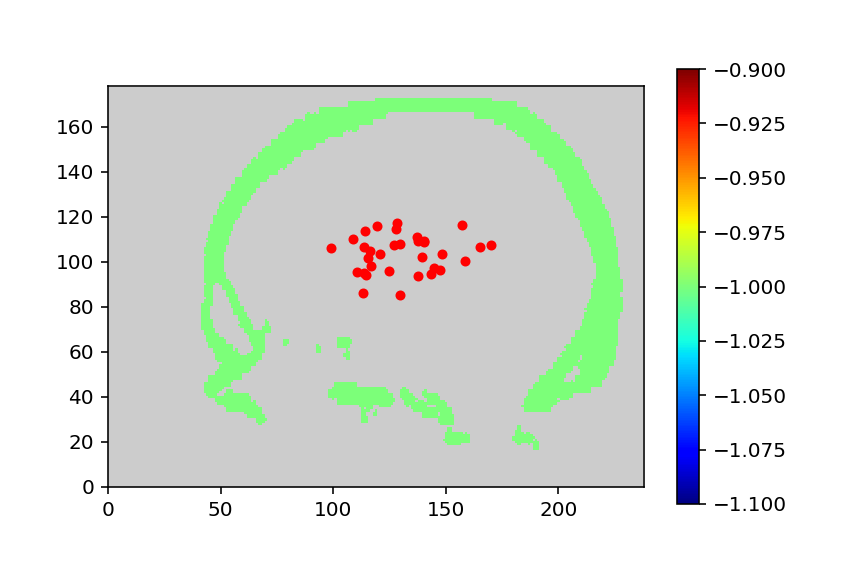

In [35]:
%matplotlib nbagg
fig, ax = plt.subplots()
palette = plt.cm.jet
palette.set_bad(alpha=0.2)
Skull_Contour[Skull_Contour==0]= np.nan
heatmap = ax.imshow(Skull_Contour.transpose(), cmap=palette)
# matplotlib.pyplot.arrow(x, y, dx, dy,head_width=4)
# matplotlib.pyplot.arrow(x, y, dx, dy,head_width=4)

for i in range(len(lesion_metrics)):
#     matplotlib.pyplot.arrow(x, y, brain_mask['vec11'][i], longlist['vec2'][i],head_width=3,color = 'red')
    plt.plot(lesion_metrics['Lesion_centroids'][i][1], lesion_metrics['Lesion_centroids'][i][2], marker='o', markersize=4, color="red")
#    plot mps centroid
#     plt.plot(np.float(lesion_metrics['centroidMPS_coord'][i].replace('(','').replace(')','').split(',')[0]), np.float(lesion_metrics['centroidMPS_coord'][i].replace('(','').replace(')','').split(',')[1]), marker='o', markersize=4, color="blue")


# green towards max MPS point
# matplotlib.pyplot.arrow(x, y, wx, wy,head_width=5,color = 'green')


# plt.plot([x], [y], marker='o', markersize=4, color="red")

# heatmap = ax.imshow(lesion_contour.transpose(), cmap=palette)
# heatmap = ax.pcolor(brain_diff==0, cmap=plt.cm.winter)
plt.ylim(0, Skull_Contour.shape[1])
plt.xlim (0,Skull_Contour.shape[0])
# ax.set_aspect(ConstPixelSpacing[2]/ConstPixelSpacing[1])
plt.colorbar(heatmap)
plt.show()
# plt.ion()

In [187]:
paths = ['/Volumes/FAIR/Registered_MPS3/SDH4/CT.nii.gz',
         '/Volumes/FAIR/Registered_MPS3/SDH7/CT.nii.gz',
         '/Volumes/FAIR/Registered_MPS3/SDH8/CT.nii.gz',
         '/Volumes/FAIR/Registered_MPS3/SDH11/CT.nii.gz',
         '/Volumes/FAIR/Registered_MPS3/SDH12/CT.nii.gz',
         '/Volumes/FAIR/Registered_MPS3/SDH14/CT.nii.gz',
         '/Volumes/FAIR/Registered_MPS3/SDH16-2/CT.nii.gz',
         '/Volumes/FAIR/Registered_MPS3/SDH24/CT.nii.gz',
         '/Volumes/FAIR/Registered_MPS3/CONT5/CT.nii.gz',
         '/Volumes/FAIR/Registered_MPS3/CONT7/CT.nii.gz',
         '/Volumes/FAIR/Registered_MPS3/EDH7/CT.nii.gz',
         '/Volumes/FAIR/Registered_MPS3/tutorial3/CT.nii.gz',
        ]
# paths = ['/Volumes/FAIR/Registered_MPS3/MPS1',
#          '/Volumes/FAIR/Registered_MPS3/MPS2',
#          '/Volumes/FAIR/Registered_MPS3/MPS3',
#          '/Volumes/FAIR/Registered_MPS3/MPS4',
#          '/Volumes/FAIR/Registered_MPS3/MPS5',
#          '/Volumes/FAIR/Registered_MPS3/MPS6',
#          '/Volumes/FAIR/Registered_MPS3/MPS7',
#          '/Volumes/FAIR/Registered_MPS3/MPS8',
#          '/Volumes/FAIR/Registered_MPS3/MPS9',
#          '/Volumes/FAIR/Registered_MPS3/MPS10',
#          '/Volumes/FAIR/Registered_MPS3/MPS11',
#          '/Volumes/FAIR/Registered_MPS3/MPS12',
#          '/Volumes/FAIR/Registered_MPS3/MPS13',
#          '/Volumes/FAIR/Registered_MPS3/MPS14',
#          '/Volumes/FAIR/Registered_MPS3/SDH4',
#          '/Volumes/FAIR/Registered_MPS3/SDH7',
#          '/Volumes/FAIR/Registered_MPS3/SDH8',
#          '/Volumes/FAIR/Registered_MPS3/SDH11',
#          '/Volumes/FAIR/Registered_MPS3/SDH12',
#          '/Volumes/FAIR/Registered_MPS3/SDH14',
#          '/Volumes/FAIR/Registered_MPS3/SDH16-2',
#          '/Volumes/FAIR/Registered_MPS3/SDH24',
#          '/Volumes/FAIR/Registered_MPS3/CONT5',
#          '/Volumes/FAIR/Registered_MPS3/CONT7',
#          '/Volumes/FAIR/Registered_MPS3/EDH7',
#          '/Volumes/FAIR/Registered_MPS3/Sample3_Pre',
#          '/Volumes/FAIR/Registered_MPS3/Sample3_Post',
#          '/Volumes/FAIR/Registered_MPS3/Sample4_Pre',
#          '/Volumes/FAIR/Registered_MPS3/tutorial3',
#          '/Volumes/FAIR/Registered_MPS3/ScanD',
#          '/Volumes/FAIR/Registered_MPS3/ScanE',
#          '/Volumes/FAIR/Registered_MPS3/ScanF',
#          '/Volumes/FAIR/Registered_MPS3/ScanH',
#         ]

for m in range(len(paths)):
# for m in range(0,1):
    path = paths[m]
    dir_name = os.path.split(path)[0]
    print( "Reading directory:", path)
    mask = sitk.ReadImage(dir_name + '/manu_Lesion.nii.gz')
    Mask_array = sitk.GetArrayFromImage(mask)
    Mask_array = np.swapaxes(Mask_array,0,2)
    ConstPixelSpacing = mask.GetSpacing()
    ID = os.path.split(path)[1]
#     Read lesion array
    Lesion_array = np.zeros(Mask_array.shape)
    # Lesion_array[Mask_array==19] = 1
    Lesion_array[Mask_array==1] = 1
    Mask_array = Lesion_array
    np.nonzero(Mask_array)
    
    volume_lesion = np.sum(BiggestRegion(Lesion_array))*ConstPixelSpacing[0]*ConstPixelSpacing[1]*ConstPixelSpacing[2]

    ID_list.append(ID)
    volume.append(volume_lesion)

Reading directory: /Volumes/FAIR/Registered_MPS3/SDH4/CT.nii.gz
Reading directory: /Volumes/FAIR/Registered_MPS3/SDH7/CT.nii.gz
Reading directory: /Volumes/FAIR/Registered_MPS3/SDH8/CT.nii.gz
Reading directory: /Volumes/FAIR/Registered_MPS3/SDH11/CT.nii.gz
Reading directory: /Volumes/FAIR/Registered_MPS3/SDH12/CT.nii.gz
Reading directory: /Volumes/FAIR/Registered_MPS3/SDH14/CT.nii.gz
Reading directory: /Volumes/FAIR/Registered_MPS3/SDH16-2/CT.nii.gz
Reading directory: /Volumes/FAIR/Registered_MPS3/SDH24/CT.nii.gz
Reading directory: /Volumes/FAIR/Registered_MPS3/CONT5/CT.nii.gz
Reading directory: /Volumes/FAIR/Registered_MPS3/CONT7/CT.nii.gz
Reading directory: /Volumes/FAIR/Registered_MPS3/EDH7/CT.nii.gz
Reading directory: /Volumes/FAIR/Registered_MPS3/tutorial3/CT.nii.gz


In [91]:
output = {'ID': ID_list, 
      'lesion_volume':volume,
     }

import pandas as pd
lesion_metrics = pd.DataFrame(data=output)
os.chdir('/Volumes/FAIR/DC-Image-Analysis/python tutorials')
lesion_metrics.to_csv('lesion_volume.csv')

In [92]:
output

{'ID': ['MPS1',
  'MPS2',
  'MPS3',
  'MPS4',
  'MPS5',
  'MPS6',
  'MPS7',
  'MPS8',
  'MPS9',
  'MPS10',
  'MPS11',
  'MPS12',
  'MPS13',
  'MPS14',
  'SDH4',
  'SDH7',
  'SDH8',
  'SDH11',
  'SDH12',
  'SDH14',
  'SDH16-2',
  'SDH24',
  'CONT5',
  'CONT7',
  'EDH7',
  'Sample3_Pre',
  'Sample3_Post',
  'Sample4_Pre',
  'tutorial3',
  'ScanD',
  'ScanE',
  'ScanF',
  'ScanH'],
 'lesion_volume': [67685.355991679884,
  71093.601869296923,
  85203.347942990513,
  39424.811881901478,
  72257.051803430091,
  79994.413715031027,
  54991.902620483605,
  49009.512101107604,
  52732.178690675639,
  145009.52615299067,
  45353.08845085268,
  72034.998006859358,
  60302.533755275894,
  145119.62005213078,
  57422.36539387326,
  75836.969523774096,
  37937.61124436478,
  29447.319022542943,
  73798.366391391595,
  186029.76657327844,
  125740.29480603612,
  67938.198760044019,
  52257.282125740763,
  23330.5766262502,
  63136.985158561038,
  139248.25643104015,
  58324.575567334992,
  59692.3523